In [1]:
import sys
sys.path.append('../')
from config import configuration
config = configuration()
config.request_password()

 ·············


In [33]:
import sqlutilpy
data_all = pd.DataFrame(
         sqlutilpy.get('''
         select * from jason_sanders.virac2_variables
         ''',
                    **config.wsdb_kwargs)
       )

In [9]:
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
chen = Table.read('/data/jls/virac/chen2018_wise.fit')

In [34]:
vvv = SkyCoord(ra=data_all['ra'].values*u.deg,dec=data_all['dec'].values*u.deg,frame='icrs')
ccc = SkyCoord(ra=chen['RAJ2000'],dec=chen['DEJ2000'],frame='icrs')

In [35]:
idx,d2d,d3d=vvv.match_to_catalog_sky(ccc)

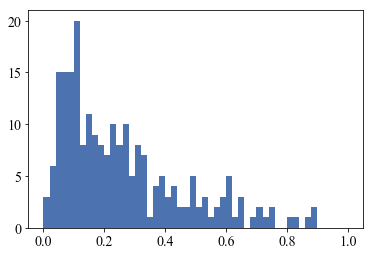

In [38]:
plt.hist(d2d.arcsec,bins=50,range=[0,1]);

[]

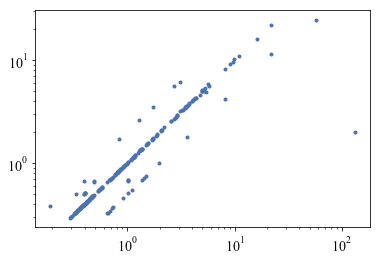

In [45]:
plt.plot(data_all['period'][d2d.arcsec<1],
         chen['Per'][idx[d2d.arcsec<1]],'.')
plt.semilogx()
plt.semilogy()

In [105]:
unqV,cntV=np.unique(data_all['class'][d2d.arcsec<1],return_counts=True)
print(unqV,cntV)

['CEP' 'CONST' 'EA/EB' 'EW' 'Ell' 'LPV' 'RRab' 'RRcd' 'T2CEP'] [ 12   1 117  78   2   1   3   1   7]


In [48]:
unq,cnt=np.unique(chen['Type'][idx[d2d.arcsec<1]],return_counts=True)

In [50]:
unq,cnt

(<Column name='Type' dtype='bytes16' length=10>
 CepI           
 CepI/CepII     
 CepI/EA        
 CepII/ACep/CepI
 EA             
 EA/RR/EW       
 EW             
 EW/EA          
 Misc           
 RR             , array([ 13,   3,   1,   2,  35,  23, 109,  21,   3,  12]))

In [61]:
unq[0]

'CepI           \r'

In [52]:
mtch_v=data_all[d2d.arcsec<1]
mtch_c=chen[idx[d2d.arcsec<1]]

In [104]:
mtch_v['sourceid'][np.argmax(mtch_v['period'])]
mtch_v['period'][np.argmax(mtch_v['period'])]
mtch_v['class'][np.argmax(mtch_v['period'])]

'LPV'

In [74]:
mtch_c[['Seq','Per']][mtch_c['Type']=='RR             \r']

Seq,Per
,d
int32,float64
38354,0.3709882
38944,0.5831723
25790,0.6849065
25781,0.7103905
22863,0.4574292
22405,0.4512771
26018,0.743553
27784,0.3270866


In [90]:
mtch_v[['class','sourceid','period']].values[mtch_c['Type']=='RR             \r']

array([['EW', 9233482002795, 0.741975929956801],
       ['RRab', 9667650003027, 0.581315738383965],
       ['EW', 11479252005705, 1.36980649398222],
       ['EA/EB', 11529194008561, 1.42636510156491],
       ['EW', 11753635021901, 0.914877734082312],
       ['RRab', 11796672007701, 0.451276494908783],
       ['EA/EB', 11819079007350, 1.487096646348482],
       ['EW', 11846067006143, 0.654160881764936],
       ['EA/EB', 11886756015552, 0.721274791994736],
       ['EA/EB', 11896193005430, 1.09399331374984],
       ['EA/EB', 11907774003062, 0.684546314094743],
       ['EA/EB', 11986800004744, 0.647293757518354]], dtype=object)

In [67]:
mtch_v['prob'].values[mtch_c['Type']=='RR             \r']

array([0.56259376, 0.9992873 , 0.62361866, 0.9224577 , 0.86612546,
       0.9975321 , 0.51271594, 0.8478497 , 0.864852  , 0.9852223 ,
       0.99566865, 0.9729538 ])

In [62]:
mtch_v['class'].values[mtch_c['Type']=='CepI           \r']

array(['EA/EB', 'CEP', 'CEP', 'CEP', 'T2CEP', 'T2CEP', 'CEP', 'CEP',
       'CEP', 'CEP', 'CEP', 'CEP', 'CEP'], dtype=object)

In [68]:
mtch_v['class'].values[mtch_c['Type']=='EA/RR/EW       \r']

array(['EA/EB', 'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB',
       'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB',
       'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB', 'EA/EB',
       'EA/EB', 'RRab'], dtype=object)

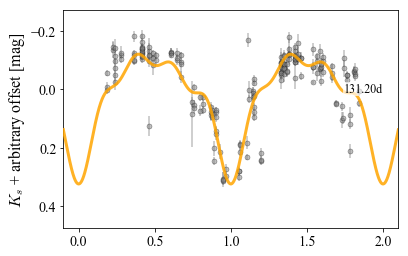

In [103]:
plot_lc_sid(11860608030302, 0.,0.,131.2017069008575,4);

In [87]:
import sys
sys.path.append('../../../../')
sys.path.append('../../../../variability/')
from fine_classif.feat_extract.compute_feats import sigclipper, correct_to_HJD, LombScargle, optimum_regularization, fourier_poly_chi2_fit_full, retrieve_fourier_poly
def get_lightcurve(sourceid):

    lcs = pd.DataFrame(sqlutilpy.get('''
                                select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_train_zyjhk where sourceid={0}'''.format(sourceid),
                     **config.wsdb_kwargs))
    
    if len(lcs)==0:

        lcs = pd.DataFrame(sqlutilpy.get('''
                                    select sourceid, 
                                    unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(emag) as emag,
                                    unnest(filterid) as filterid,
                                    unnest(chi) as chi,
                                    unnest(ast_res_chisq) as ast_res_chisq,
                                    unnest(ambiguous_match) as ambiguous_match  
                                    from leigh_smith.virac2_ts_tmolnar_variables where sourceid={0}'''.format(sourceid),
                         **config.wsdb_kwargs))
    
    return lcs

def load_lc(sid, ra, dec):
    lc=get_lightcurve(sid)
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<11.829)&\
        (~((lc['chi']>5.)&(lc['mag']<13.2)))
    lc = sigclipper(lc[clean])

    correct_to_HJD(lc,
                 ra,
                 dec)
    return lc

def plot_lc_sid(sid,ra,dec,per,nterms,ax=None,reg=True,xlabel=False,right=False,offs=0,pcolor='gray',
               mcolor='#FFA500',ps='o',ttitle='',ylabel=True):
    
    lc = load_lc(sid, ra, dec)

    tt = lc['HJD'].values[np.argmin(np.abs(lc['mag'].values-np.nanpercentile(lc['mag'],98.)))]

    model = LombScargle(lc['HJD'].values-tt, lc['mag'].values, 
                        lc['emag'].values, normalization='standard')
    freq, power = model.autopower(maximum_frequency=10.)

    if xlabel:
        plt.xlabel('Phase')
    if ylabel:
        plt.ylabel(r'$K_s$ + arbitrary offset [mag] ')
#     nterms=combo_dset['lsq_nterms'].values[fltr][ii]
    opt_reg=0
    if reg:
        opt_reg=optimum_regularization(lc['mag'].values, lc['emag'].values)

    results_d = fourier_poly_chi2_fit_full(
                                             times=lc['HJD'].values-tt,
                                             mag=lc['mag'].values,
                                             err=lc['emag'].values,
                                             freq_dict={'freq_grid':np.array([1./per])},
                                             nterms=np.int64(nterms),
                                             npoly=2,
                                             regularization=opt_reg,
                                             time_zeropoint_poly=0.,
                                             regularize_by_trace = True,
                                             check_multiples=False, 
                                             use_power_of_2=False,
                                             return_period_error=False)

    xx=np.linspace(-1.1*per,3.1*per,5000)
    FF = retrieve_fourier_poly(xx,
                               results_d)
    xx0 = xx[np.argmax(FF[xx<0])]
    
    plt.errorbar((((lc['HJD'].values-tt-xx0)%(2.*per))/per),
                 lc['mag'].values-np.nanmedian(FF)+offs,
                 yerr=lc['emag'].values,fmt=ps,color=pcolor,mew=0.5,mec='k',alpha=0.5,ms=5,
                rasterized=True)
#     plt.ylim(np.nanmean(lc['mag'].values)-0.3,np.nanmean(lc['mag'].values)+0.3)
    plt.gca().invert_yaxis()
    plt.xlim(-0.1,2.1)
    # plt.ylim(-0.5,0.5)
    
    tt = plt.annotate('%0.2fd'%per,xy=(2.,offs),ha='right',va='center',zorder=100,fontsize=12)
    tt.set_bbox({'facecolor':'white', 'alpha':0.7,'edgecolor':'None','pad':1.})
    
    plt.plot((xx-xx0)/per, FF-np.nanmedian(FF)+offs,color=mcolor,lw=3,zorder=10,alpha=0.85)

    if offs==0:
        plt.ylim(np.nanmax(FF)+0.15-np.nanmedian(FF),np.nanmin(FF)-0.15-np.nanmedian(FF))
    
    if right:
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
    plt.title(ttitle,fontsize=16)
    return results_d